# BA870 - Project
## Lai Zhang




# Import necessary packages and libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats.mstats import winsorize
from pathlib import Path  
from google.colab import drive
# prepare for data loading
drive.mount('/content/gdrive/') 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive/


# (1) Collect data for your project based on ticker symbols from the Russell 3000 index:

## a. Upload the set of stocks will be provided in a CSV file with the list of ticker symbols (“ProjectTickers.csv”).

In [2]:
ProjectTickers = pd.read_csv('/content/gdrive/MyDrive/ProjectTickers.csv')

In [3]:
ProjectTickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


## b. Upload monthly stock return data from January 2017 - December 2021 (60 months) for each of the stocks with tickers in the file “ProjectTickers.csv”.


In [4]:
data = pd.read_csv('/content/gdrive/MyDrive/Project-2017-21-Returns.csv')

### Examine varaibles in dataframe

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


In [6]:
# Check the number of stocks
len(data['TICKER'].unique())

1925

In [7]:
# Keep the stocks we need (1886)
dt = data.loc[data['TICKER'].isin(ProjectTickers.Ticker)]
print('Now the number of stocks is', len(dt['TICKER'].unique()))
print('The total number of returns is',len(dt['RET']))

Now the number of stocks is 1886
The total number of returns is 113160


In [8]:
# Check the null values
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113160 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  113160 non-null  int64 
 1   date    113160 non-null  int64 
 2   TICKER  113160 non-null  object
 3   RET     113160 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.3+ MB


In [9]:
# Check the returns that only contain number
dt.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

PERMNO     True
date       True
TICKER    False
RET       False
dtype: bool

In [10]:
# Check the RET abnormal value
dt.sort_values('RET', ascending=False)

,PERMNO,date,TICKER,RET
33255,16498,20170131,HGV,C
33795,16560,20170131,REVG,C
35710,20064,20201231,AAN,C
33915,16570,20170131,JNCE,C
33555,16543,20170131,VREX,C
...,...,...,...,...
19376,14566,20200630,FPI,-0.000000
78613,83879,20180629,LAMR,-0.000000
14745,14036,20190731,DOC,-0.000000
11299,13622,20170531,RLGY,-0.000000


According to the result, we find that RET. supposed to only have numerical value, contains 'C', which is a string.

In [11]:
# Select the rows when the RET is 'C'
temp = dt.loc[dt.RET == 'C']
temp

,PERMNO,date,TICKER,RET
33195,16497,20170131,CNDT,C
33255,16498,20170131,HGV,C
33315,16499,20170131,PK,C
33555,16543,20170131,VREX,C
33675,16554,20170131,JELD,C
33795,16560,20170131,REVG,C
33855,16562,20170131,ANAB,C
33915,16570,20170131,JNCE,C
34813,18420,20190329,FOXA,C
35148,19283,20200430,ARNC,C


In [12]:
# Use  NaN to replace the string, 'C'
dt['RET'].replace('C', np.nan, inplace = True)
dt.RET = dt['RET'].astype('float')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
dt.groupby('TICKER').count()

,PERMNO,date,RET
TICKER,,,
A,60,60,60
AA,60,60,60
AAL,60,60,60
AAN,60,60,59
AAON,60,60,60
...,...,...,...
ZEN,60,60,60
ZION,60,60,60
ZNGA,60,60,60


CNDT


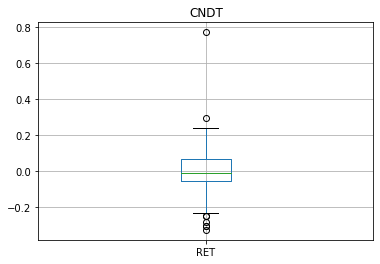

HGV


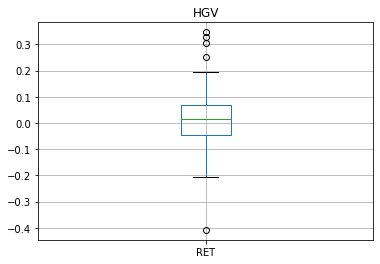

PK


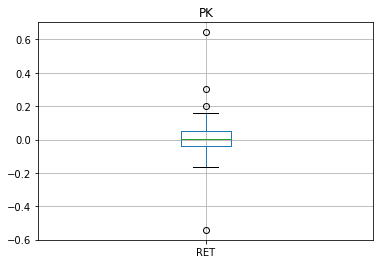

VREX


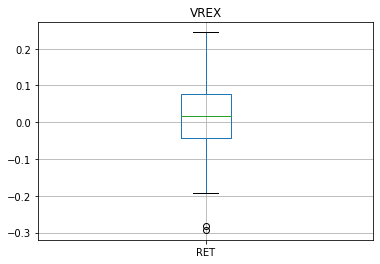

JELD


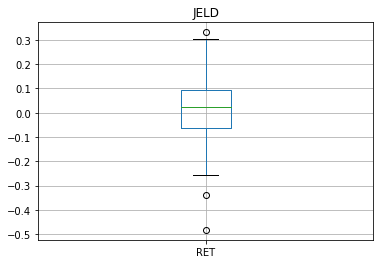

REVG


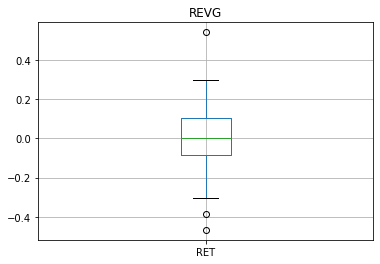

ANAB


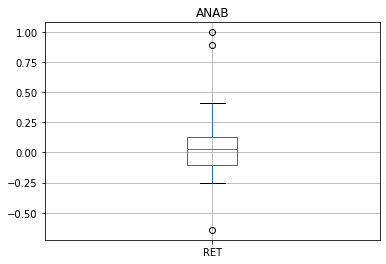

JNCE


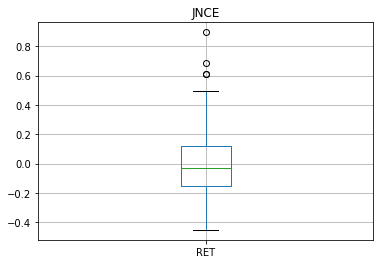

FOXA


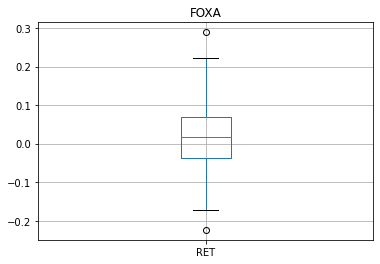

ARNC


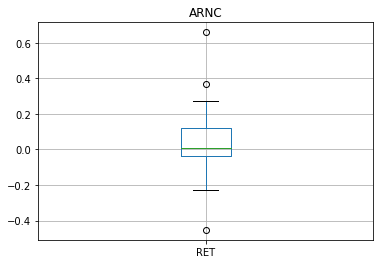

AAN


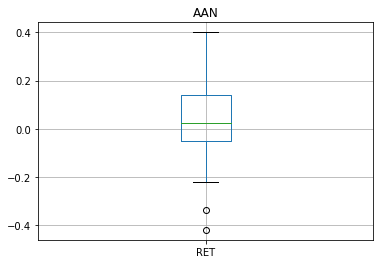

In [14]:
# Check outliers of 'RET' by using boxplot

for i in temp.TICKER:
    print(i)
    
    plt.figure()
    plt.title(i)
    a = dt[dt['TICKER']==i]
    a.boxplot(column='RET')

    plt.show()

According to the boxplot of different tickers with null value, each plot has outliers so I decide to use median to replace NaN in order to keep the mean constant.

In [15]:
temp1 = dt[['TICKER','RET']]
# Fill the median of 'RET' into null values relative to different stocks
for i in temp.TICKER:
  mask = dt['TICKER']==i
  a = temp1[temp1['TICKER'] == i].median()
  dt.loc[mask] = dt.loc[mask].fillna(a)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [16]:
# Check the null values is filled by the median value
a= temp.index
dt.iloc[a]

,PERMNO,date,TICKER,RET
33425,16505,20210331,BPOP,0.058366
33485,16515,20210331,IIPR,-0.069333
33545,16525,20210331,ICHR,0.258185
33785,16555,20210331,UVV,0.160764
33905,16562,20210331,ANAB,-0.249129
34025,16600,20210331,HSY,0.085891
34085,16678,20210331,KR,0.117355
34180,17005,20190531,CVS,-0.036962
35079,18973,20210528,BRC,0.048745
35415,19583,20170731,IVZ,-0.011935


In [17]:
# Check the dataframe that not contain abnormal value
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113160 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  113160 non-null  int64  
 1   date    113160 non-null  int64  
 2   TICKER  113160 non-null  object 
 3   RET     113160 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.3+ MB


### i. Load the “Fama-French” factor returns data from Assignment #3.

In [18]:
ff_factors = pd.read_csv('/content/gdrive/MyDrive/FF-Factors-2017-2021.csv')

In [19]:
# Rename date column to "date" to match WRDS data "date" column
ff_factors.rename(columns={'dateff':'date'}, inplace=True)
ff_factors.head()

,date,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


## c. Upload Financial Report data for the year 2021 for each of the stocks with tickers in the file “ProjectTickers.csv”.

Financial Variables Download:

  
- `at`--Total Assets (AT)  
- `csho`-- Common Shares Outstanding (CSHO)  
- `dvpsp_c`-- Dividends per Share - Pay Date - Calendar (DVPSP_C) 
- `dvt`--Total Dividends (DVT)   
- `ebit`-- Earnings Before Interest and Taxes (EBIT)   
- `epsfx`-- Earnings Per Share (Diluted) Excluding Extraordinary Items (EPSFX)
- `ib`-- Income Before Extraordinary Items (IB)  
- `gp`-- Gross Profit (Loss) (GP)  
- `ni` -- Net Income (Loss) (NI)
- `sale`-- Sales/Turnover (Net) (SALE)
- `prcc_c`-- Price Close - Annual - Calendar (PRCC_C) 
- `ceq`-- Common/Ordinary Equity - Total (CEQ)

In [20]:
ratios = pd.read_csv('/content/gdrive/MyDrive/Project-2021-Financials.csv')

In [21]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   at        1886 non-null   float64
 10  ceq       1886 non-null   float64
 11  csho      1886 non-null   float64
 12  dvt       1877 non-null   float64
 13  ebit      1886 non-null   float64
 14  epsfx     1886 non-null   float64
 15  gp        1886 non-null   float64
 16  ib        1886 non-null   float64
 17  ni        1886 non-null   float64
 18  sale      1886 non-null   float64
 19  costat    1886 non-null   object 
 20  dvpsp_c   1886 non-null   floa

In [22]:
# Check the null value
ratios.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
at          0
ceq         0
csho        0
dvt         9
ebit        0
epsfx       0
gp          0
ib          0
ni          0
sale        0
costat      0
dvpsp_c     0
prcc_c      0
dtype: int64

In [23]:
# Chech the stocks without dividends
temp = ratios.loc[ratios.dvt.isnull()]
temp.tic

185       GE
208       HL
334      PCG
963      BLX
1113     SPG
1135     PLD
1313     NAT
1522    GOOD
1638      DK
Name: tic, dtype: object

dvt


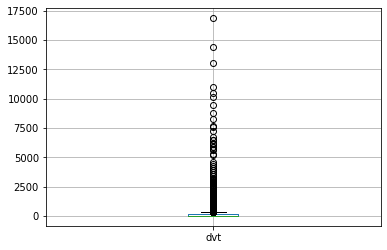

In [24]:
# Check outliers by using boxplot
tmp = ratios[['dvt']]
for i in tmp.columns:
    print(i)
    plt.figure()
    
    tmp.boxplot(column=i)
    

    plt.show()

### Missing Value Imputation

According to the results above, there exist 9 missing values in `dvt`. We decide to use the median of `dvt` to fill the missing value because the data of `dvt` is extremely skewed and the outliers will have effects on mean.


In [25]:
for i in tmp:
  mask = i
  a = tmp[i].median()
  ratios[mask] = ratios[mask].fillna(a)

In [26]:
# Check the whole variables that not contain NaN
ratios.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
at          0
ceq         0
csho        0
dvt         0
ebit        0
epsfx       0
gp          0
ib          0
ni          0
sale        0
costat      0
dvpsp_c     0
prcc_c      0
dtype: int64

In [27]:
ratios.describe()

,gvkey,datadate,fyear,at,ceq,csho,dvt,ebit,epsfx,gp,ib,ni,sale,dvpsp_c,prcc_c
count,1886.000000,1.886000e+03,1886.000000,1.886000e+03,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,62189.838282,2.021110e+07,2020.911983,2.622079e+04,5024.835206,216.216609,296.486549,1309.807222,4.117346,3100.748268,927.990629,942.737848,8418.783976,0.974461,104.209820
std,67853.146760,2.954896e+02,0.283395,1.493189e+05,16277.563302,617.870176,1089.508029,5154.949448,16.398417,11434.443859,4191.565699,4208.808452,28707.012557,1.749157,236.957951
min,1004.000000,2.021013e+07,2020.000000,2.689900e+01,-14999.000000,1.161000,-0.128000,-6273.000000,-95.530000,-2155.000000,-9501.000000,-9501.000000,-69.296000,0.000000,0.355500
25%,11641.250000,2.021123e+07,2021.000000,1.291068e+03,416.276000,37.220250,0.000000,48.110500,0.260000,216.591250,16.018250,16.138750,513.042750,0.000000,25.022500
50%,25281.000000,2.021123e+07,2021.000000,4.124783e+03,1109.486000,73.807500,19.000000,211.177000,2.280000,625.601000,133.259000,135.238000,1596.892000,0.387500,51.940000
75%,125591.250000,2.021123e+07,2021.000000,1.307137e+04,3316.116500,176.940000,127.750000,807.034250,5.040000,1966.419250,542.250000,554.200000,5560.085500,1.300000,107.657500
max,317264.000000,2.021123e+07,2021.000000,3.743567e+06,259289.000000,16426.786000,16871.000000,108949.000000,490.360000,220387.000000,94680.000000,94680.000000,556933.000000,28.060000,5908.870000


## d. Upload Industry Identifier data for the year 2021 for each of the stocks with tickers in the file “ProjectTickers.csv”.

In [28]:
sector_fiscal = pd.read_csv('/content/gdrive/MyDrive/Project-2021-Sector-fiscal.csv')
sector_fiscal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1797 non-null   int64 
 1   datadate  1797 non-null   int64 
 2   fyear     1797 non-null   int64 
 3   indfmt    1797 non-null   object
 4   consol    1797 non-null   object
 5   popsrc    1797 non-null   object
 6   datafmt   1797 non-null   object
 7   tic       1797 non-null   object
 8   curcd     1797 non-null   object
 9   costat    1797 non-null   object
 10  ggroup    1797 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 154.6+ KB


In [29]:
sector = pd.read_csv('/content/gdrive/MyDrive/Project-2021-Sector.csv')
sector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1886 non-null   int64 
 1   datadate  1886 non-null   int64 
 2   fyear     1886 non-null   int64 
 3   indfmt    1886 non-null   object
 4   consol    1886 non-null   object
 5   popsrc    1886 non-null   object
 6   datafmt   1886 non-null   object
 7   tic       1886 non-null   object
 8   curcd     1886 non-null   object
 9   costat    1886 non-null   object
 10  ggroup    1886 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 162.2+ KB


             count
data date     1886
data fiscal   1797


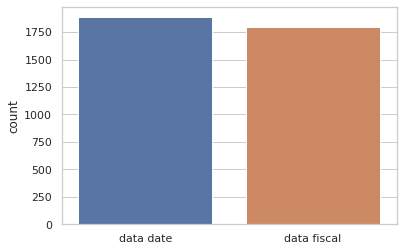

In [30]:
sector_count=pd.DataFrame(data = {'count':[len(sector),len(sector_fiscal)]},index=['data date','data fiscal'])
print(sector_count)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=sector_count.index, y='count', data=sector_count)
plt.show()

Accroding to the result of the barplot, we can find that 'data date' contains more data so we can choose to use this data for the following steps.

# (2) Determine Risk Exposures

## a. Calculate the Fama-French Risk Exposures for the list of 3,000 tickers for (i) Market Risk Exposure; (ii) Size Risk Exposure; and (iii) Value/Distress Risk Expsoure.


In [31]:
# Create a LOOP that will perform the following tasks for each of the 1886 stocks
result =pd.DataFrame()
for i in dt["TICKER"].drop_duplicates():

  a = dt[dt["TICKER"] == i]
# (a) Merge the stocks returns (60 months) for each stock with 
#    the FF Risk Factor data ("FF-Factors-2017-2021.csv")
  b = pd.merge(a, ff_factors, on='date', how='outer')

# (b) Run an OLS regression for each stock (60 months) using FF 3-Factor model:
#  [Ret(MSFT)-Rf] = alpha + B1(RetMkt-Rf) + b2(SMB) + b3(HML) + e
  y = b["RET"] - b["rf"]
  X = b[['mktrf' , 'smb' , 'hml']]  
  # Use statsmodels
  X = sm.add_constant(X) # adding a constant
  model = sm.OLS(y, X).fit()

# (c) Extract the following output items from the regression results:
  d = model.rsquared
  e = model.rsquared_adj
  c = model.params

  output = pd.DataFrame({'TICKER':i,
            'mktrf':c[1],
            'smb':c[2],
            'hml':c[3]},index=[0])
  
# (d) Store the above items (mktrf, smb, hml) to a row in a dataframe.
  result=result.append(output)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
# Check the outputs
Risk_Exposures = result.reset_index().drop(columns=['index'])
Risk_Exposures

,TICKER,mktrf,smb,hml
0,JJSF,0.452887,0.356829,0.524302
1,PLXS,0.955657,0.229663,0.598402
2,ORCL,0.839476,-0.587083,0.016158
3,MSFT,0.935809,-0.330320,-0.401040
4,TROW,1.121489,0.008855,0.145466
...,...,...,...,...
1881,SIX,2.062411,1.129428,0.780178
1882,VPG,1.202745,0.953927,0.093573
1883,FN,0.697870,0.905014,0.087299
1884,CBOE,0.621143,-0.399150,0.339880


In [33]:
Risk_Exposures.describe()

,mktrf,smb,hml
count,1886.000000,1886.000000,1886.000000
mean,1.065369,0.667275,0.317248
std,0.624558,1.232195,0.699352
min,-6.676723,-6.286219,-3.593321
25%,0.720385,0.016011,-0.047773
50%,1.006944,0.501588,0.360752
75%,1.337691,1.019407,0.760726
max,6.002016,31.005941,5.919490


### EDA for three risk exposures
- The mean of `mktrf` of these stocks are larger than 1, means that most of them are more exposed on average than most stocks compare to the market fluctuation.
- The mean of `smb` of these stocks are larger than 0, means that most of them are small stocks, which have more riskiness.
- The mean of `hml` of these stocks are larger than 0, means that most of them are valued stocks.

risk


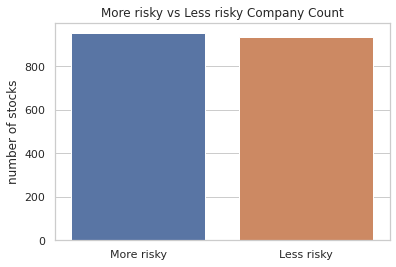

size


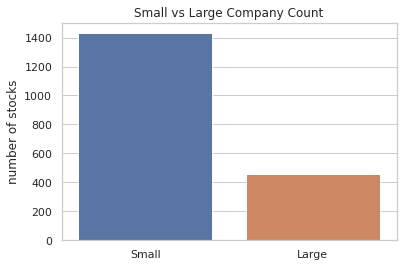

valued


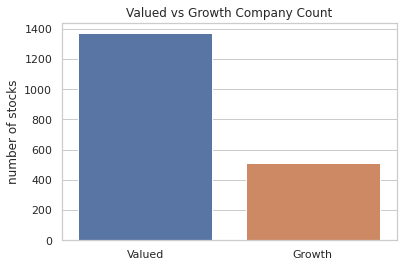

In [34]:
plots = pd.DataFrame()
plots['risk'] = np.where(Risk_Exposures['mktrf']<1,'Less risky','More risky')
plots['size'] = np.where(Risk_Exposures['smb']<0,'Large','Small')
plots['valued'] = np.where(Risk_Exposures['hml']>0,'Valued','Growth')


sns.set_theme(style="whitegrid")
for i in plots:
  print(i)
  plots_ct = plots[i].value_counts()
  plots_ct = pd.DataFrame(plots_ct)
  ax = sns.barplot(x=plots_ct.index, y=i, data=plots_ct)
  plt.ylabel('number of stocks')
  plt.title(plots_ct.index[0]+' '+'vs'+' '+ plots_ct.index[1]+' '+'Company Count')
  plt.show()  

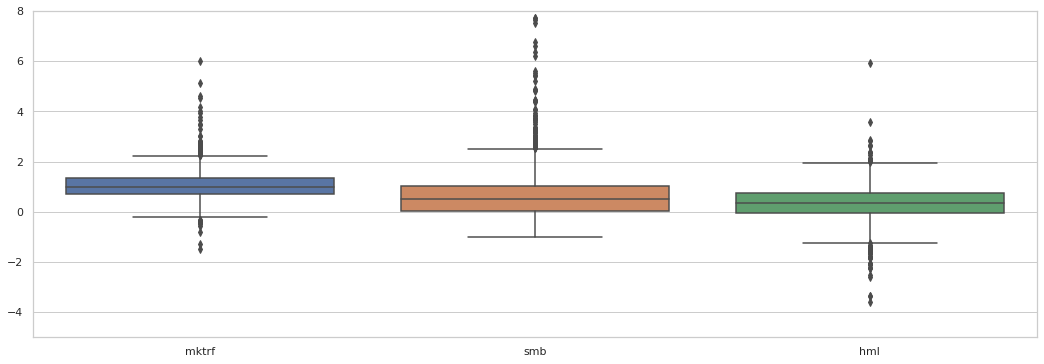

In [35]:
plt.figure(figsize=(18,6))
sns.boxplot(data=Risk_Exposures)
plt.ylim([-5,8]) 
plt.show()

## b. Save the ticker symbol and the 3 exposure values for each stock in the list in a CSV file labelled “FF-Exposures.csv”.

In [36]:
filepath = Path('/content/gdrive/MyDrive/FF-Exposures.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Risk_Exposures.to_csv(filepath) 

# (3) Calculate Financial Ratios

## a. Based on the Lectures in BA870, calculate relevant financial ratios
(including market ratios) that you believe might explain a company’s stock
return in early 2022

In [37]:
# Check the finacial variables needed
ratios.columns

Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'curcd', 'at', 'ceq', 'csho', 'dvt', 'ebit', 'epsfx', 'gp', 'ib',
       'ni', 'sale', 'costat', 'dvpsp_c', 'prcc_c'],
      dtype='object')

In [38]:
# Creates 4 "Market Ratios" for each stock from the Compustat data
# Valuation ratio
# - Price/Book = (PRCC_C * CSHO ) / CEQ
# - P/E = (PRCC_C * CSHO ) / NI
# - P/EBIT = (PRCC_C * CSHO ) / EBIT
# - P/SALES = (PRCC_C * CSHO ) / SALE
ratios['Price/Book'] = (ratios['prcc_c']*ratios['csho'])/ratios['ceq']
ratios['P/E'] = (ratios['prcc_c']*ratios['csho'])/ratios['ni']
ratios['P/EBIT'] = (ratios['prcc_c']*ratios['csho'])/ratios['ebit']
ratios['P/SALES'] = (ratios['prcc_c']*ratios['csho'])/ratios['sale']

# Create other ratios

# Valuation ratio
# Price per share-to-Earnings per share, excl. Extraordinary Items (diluted)
ratios['pe_exi'] = ratios['prcc_c']/ratios['epsfx']
# dividend / price 
ratios['divyield'] = ratios['dvt']/(ratios['csho']*ratios['prcc_c']) 
# Dividends as a fraction of Income Before Extra. Items
ratios['Dividend Payout Ratio'] = ratios['dvt']/ratios['ib']

# financial leverage ratio
ratios['Equity Multiplier'] = ratios['at'] / ratios['ceq']

# Profitability ratio
ratios['net income margin'] = ratios['ni']/ratios['sale']
ratios['Gross Profit/Total Assets'] = ratios['gp']/ratios['at']
ratios['ROA'] = ratios['ebit']/ratios['at']
ratios['ROE'] = ratios['ni']/ratios['ceq']

In [39]:
# Invert each of the ratios to make them "better behaved"

ratios['Book/Price'] = 1/ratios['Price/Book']
ratios['E/P'] = 1/ratios['P/E']
ratios['EBIT/P'] = 1/ratios['P/EBIT']
ratios['SALE/P'] = 1/ratios['P/SALES']
ratios['1/nim'] = 1/ratios['net income margin']
ratios['1/pe_exi'] = 1/ratios['pe_exi']

In [40]:
# Drop the market ratio after inverting
ratios.drop(columns = ['Price/Book', 'P/E', 'P/EBIT','P/SALES','net income margin','pe_exi'], inplace=True)

In [41]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gvkey                      1886 non-null   int64  
 1   datadate                   1886 non-null   int64  
 2   fyear                      1886 non-null   int64  
 3   indfmt                     1886 non-null   object 
 4   consol                     1886 non-null   object 
 5   popsrc                     1886 non-null   object 
 6   datafmt                    1886 non-null   object 
 7   tic                        1886 non-null   object 
 8   curcd                      1886 non-null   object 
 9   at                         1886 non-null   float64
 10  ceq                        1886 non-null   float64
 11  csho                       1886 non-null   float64
 12  dvt                        1886 non-null   float64
 13  ebit                       1886 non-null   float

In [42]:
# Check the null value of each ratio
ratios.isnull().sum()

gvkey                        0
datadate                     0
fyear                        0
indfmt                       0
consol                       0
popsrc                       0
datafmt                      0
tic                          0
curcd                        0
at                           0
ceq                          0
csho                         0
dvt                          0
ebit                         0
epsfx                        0
gp                           0
ib                           0
ni                           0
sale                         0
costat                       0
dvpsp_c                      0
prcc_c                       0
divyield                     0
Dividend Payout Ratio        0
Equity Multiplier            0
Gross Profit/Total Assets    0
ROA                          0
ROE                          0
Book/Price                   0
E/P                          0
EBIT/P                       0
SALE/P                       0
1/nim   

In [43]:
ratios.describe()

,gvkey,datadate,fyear,at,ceq,csho,dvt,ebit,epsfx,gp,...,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
count,1886.000000,1.886000e+03,1886.000000,1.886000e+03,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,...,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,62189.838282,2.021110e+07,2020.911983,2.622079e+04,5024.835206,216.216609,296.486549,1309.807222,4.117346,3100.748268,...,1.469272,0.217461,0.047180,0.023312,0.422120,0.027009,0.060538,0.765997,16.520010,0.020671
std,67853.146760,2.954896e+02,0.283395,1.493189e+05,16277.563302,617.870176,1089.508029,5154.949448,16.398417,11434.443859,...,89.376561,0.235335,0.157399,10.319606,0.424100,0.136353,0.130324,1.439881,338.241713,0.143227
min,1004.000000,2.021013e+07,2020.000000,2.689900e+01,-14999.000000,1.161000,-0.128000,-6273.000000,-95.530000,-2155.000000,...,-3095.952381,-1.384604,-1.420596,-364.326147,-2.056645,-1.891725,-1.334204,-0.087004,-2719.142117,-1.955975
25%,11641.250000,2.021123e+07,2021.000000,1.291068e+03,416.276000,37.220250,0.000000,48.110500,0.260000,216.591250,...,1.770975,0.058168,0.018602,0.027054,0.161112,0.008113,0.019641,0.176223,2.341540,0.007117
50%,25281.000000,2.021123e+07,2021.000000,4.124783e+03,1109.486000,73.807500,19.000000,211.177000,2.280000,625.601000,...,2.552746,0.198943,0.053231,0.115155,0.337004,0.036704,0.056821,0.350729,5.791435,0.035480
75%,125591.250000,2.021123e+07,2021.000000,1.307137e+04,3316.116500,176.940000,127.750000,807.034250,5.040000,1966.419250,...,4.577301,0.332409,0.106175,0.218230,0.613868,0.076322,0.113822,0.814565,12.766705,0.072964
max,317264.000000,2.021123e+07,2021.000000,3.743567e+06,259289.000000,16426.786000,16871.000000,108949.000000,490.360000,220387.000000,...,1347.744089,2.845149,1.908472,216.142857,7.547555,0.898517,0.974888,27.543662,13507.605839,0.674523


## Deal with missing values and outliers.

In [44]:
# Select hte ratio columns to prepare for checking outliers
cols = ratios.columns[-12:]
df = ratios[cols]
df.describe()

,divyield,Dividend Payout Ratio,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.015208,0.371677,1.469272,0.217461,0.047180,0.023312,0.422120,0.027009,0.060538,0.765997,16.520010,0.020671
std,0.028262,4.079297,89.376561,0.235335,0.157399,10.319606,0.424100,0.136353,0.130324,1.439881,338.241713,0.143227
min,-0.000013,-90.398959,-3095.952381,-1.384604,-1.420596,-364.326147,-2.056645,-1.891725,-1.334204,-0.087004,-2719.142117,-1.955975
25%,0.000000,0.000000,1.770975,0.058168,0.018602,0.027054,0.161112,0.008113,0.019641,0.176223,2.341540,0.007117
50%,0.007126,0.092851,2.552746,0.198943,0.053231,0.115155,0.337004,0.036704,0.056821,0.350729,5.791435,0.035480
75%,0.022818,0.371872,4.577301,0.332409,0.106175,0.218230,0.613868,0.076322,0.113822,0.814565,12.766705,0.072964
max,0.738044,118.595914,1347.744089,2.845149,1.908472,216.142857,7.547555,0.898517,0.974888,27.543662,13507.605839,0.674523


### Check the outliers

divyield


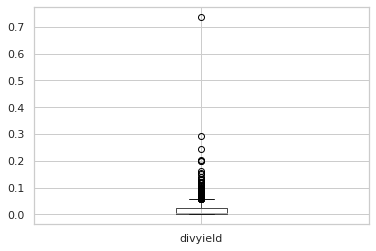

Dividend Payout Ratio


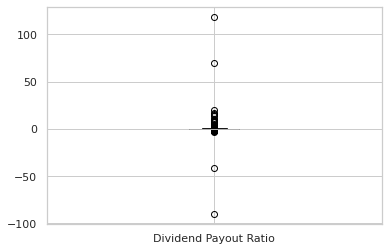

Equity Multiplier


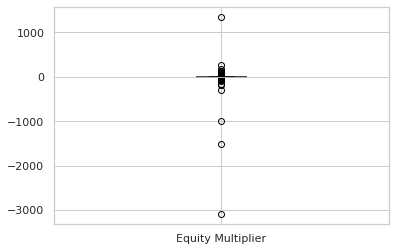

Gross Profit/Total Assets


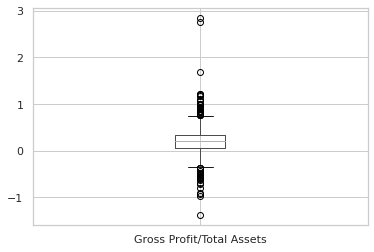

ROA


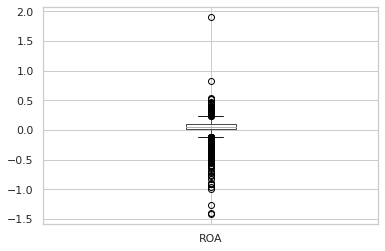

ROE


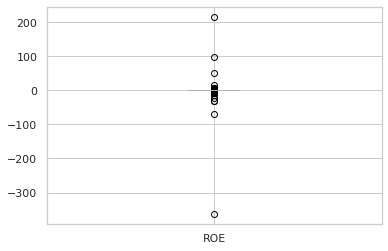

Book/Price


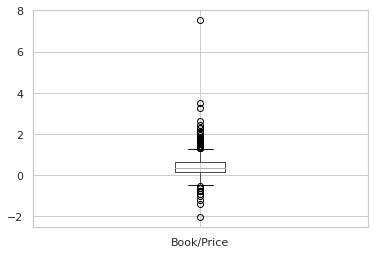

E/P


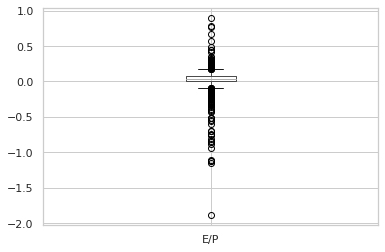

EBIT/P


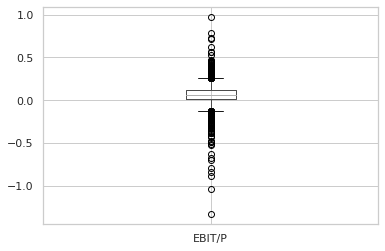

SALE/P


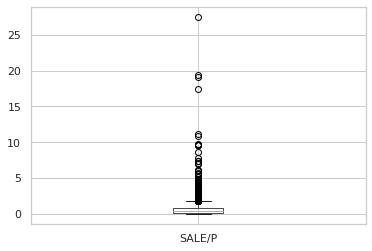

1/nim


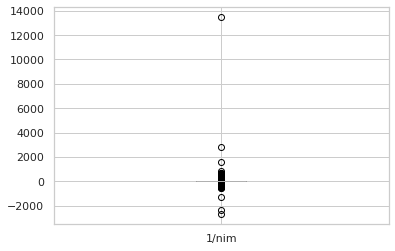

1/pe_exi


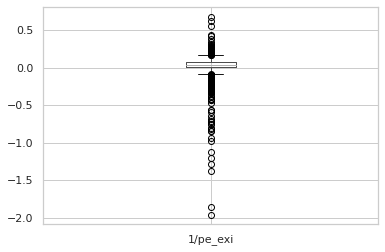

In [45]:
# Check outliers by using boxplot
for i in df:
    print(i)
    plt.figure()
    df.boxplot(column=i)
    plt.show()

divyield


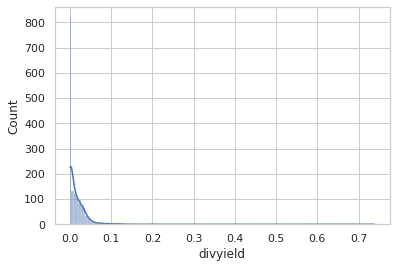

Dividend Payout Ratio


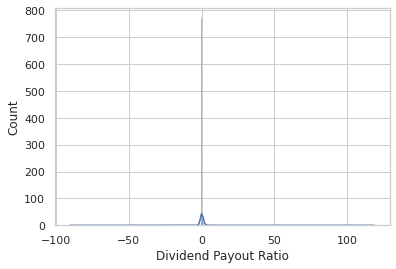

Equity Multiplier


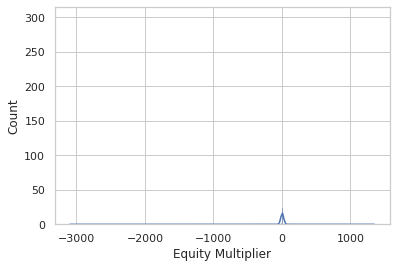

Gross Profit/Total Assets


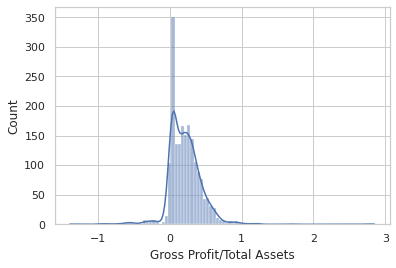

ROA


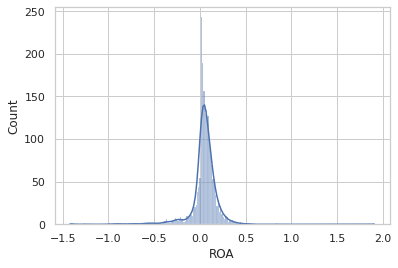

ROE


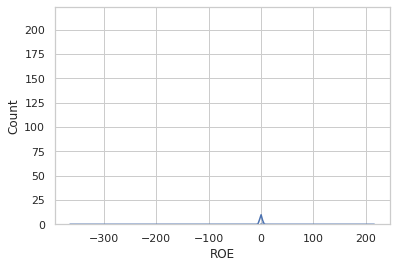

Book/Price


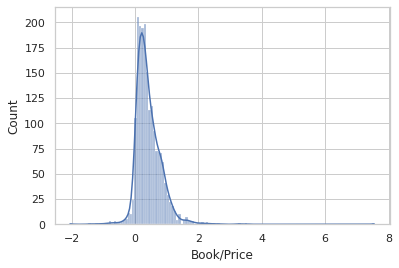

E/P


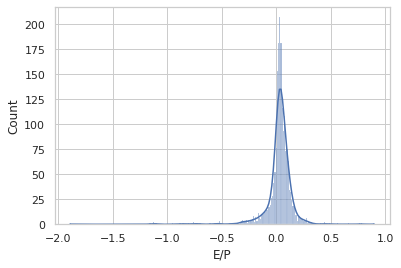

EBIT/P


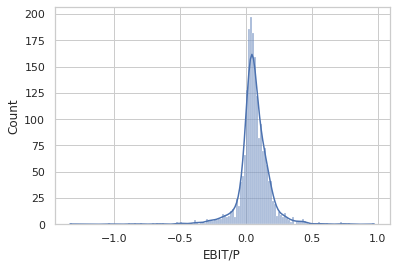

SALE/P


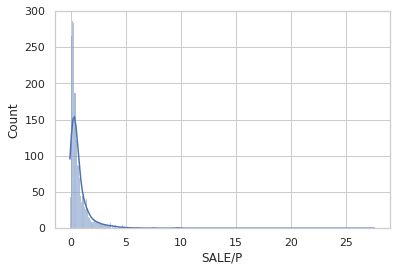

1/nim


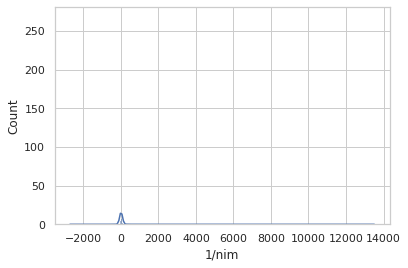

1/pe_exi


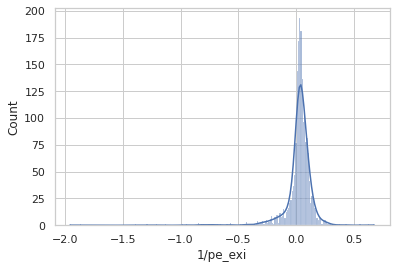

In [46]:
# Check outliers by using histplot
for i in df:
    print(i)
    plt.figure()
    # data.boxplot(column=i)
    sns.histplot(df[i],kde=True)
    plt.show()

In [47]:
df.describe()

,divyield,Dividend Payout Ratio,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.015208,0.371677,1.469272,0.217461,0.047180,0.023312,0.422120,0.027009,0.060538,0.765997,16.520010,0.020671
std,0.028262,4.079297,89.376561,0.235335,0.157399,10.319606,0.424100,0.136353,0.130324,1.439881,338.241713,0.143227
min,-0.000013,-90.398959,-3095.952381,-1.384604,-1.420596,-364.326147,-2.056645,-1.891725,-1.334204,-0.087004,-2719.142117,-1.955975
25%,0.000000,0.000000,1.770975,0.058168,0.018602,0.027054,0.161112,0.008113,0.019641,0.176223,2.341540,0.007117
50%,0.007126,0.092851,2.552746,0.198943,0.053231,0.115155,0.337004,0.036704,0.056821,0.350729,5.791435,0.035480
75%,0.022818,0.371872,4.577301,0.332409,0.106175,0.218230,0.613868,0.076322,0.113822,0.814565,12.766705,0.072964
max,0.738044,118.595914,1347.744089,2.845149,1.908472,216.142857,7.547555,0.898517,0.974888,27.543662,13507.605839,0.674523


In [48]:
# Check the number outliers by using IQR
dt1 = []

for i in df:

  q1 = df[i].quantile(0.25)
  q3 = df[i].quantile(0.75)
  IQR = q3 - q1 
  lower_lim = q1-1.5 * IQR
  upper_lim = q3+1.5 * IQR
  
  outliers_low = (df[i]<lower_lim).astype('int')
  outliers_up = (df[i]>upper_lim).astype('int')

  dt1.append([outliers_low.sum(),outliers_up.sum()])
IQR_df = pd.DataFrame(data=dt1,columns=['outliers_low','outliers_up'],index=df.columns)
IQR_df

,outliers_low,outliers_up
divyield,0,68
Dividend Payout Ratio,35,156
Equity Multiplier,64,219
Gross Profit/Total Assets,23,30
ROA,127,78
ROE,165,139
Book/Price,12,45
E/P,146,70
EBIT/P,93,76
SALE/P,0,175


In [49]:
# Tures to exact boundary points
IQR_df.outliers_low = IQR_df.outliers_low/1886
IQR_df.outliers_up = IQR_df.outliers_up/1886
IQR_df

,outliers_low,outliers_up
divyield,0.000000,0.036055
Dividend Payout Ratio,0.018558,0.082715
Equity Multiplier,0.033934,0.116119
Gross Profit/Total Assets,0.012195,0.015907
ROA,0.067338,0.041357
ROE,0.087487,0.073701
Book/Price,0.006363,0.023860
E/P,0.077413,0.037116
EBIT/P,0.049311,0.040297
SALE/P,0.000000,0.092789


### Handling the outliers

After checking the outliers of each ratio by using the boxplot, histplot and IQR method, we can conclude that all ratios have outliers. Thus, we use Winsorize Method to handle them. 

In [50]:
# Use the the exact points from IQR calculation and apply them as boundaries
for i in IQR_df.index:
  ratios[i] = winsorize(ratios[i],(IQR_df.outliers_low[i],IQR_df.outliers_up[i]))

divyield


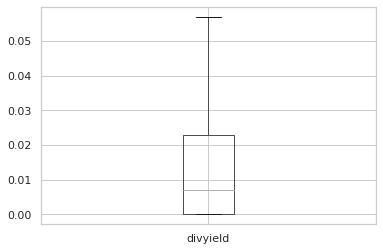

Dividend Payout Ratio


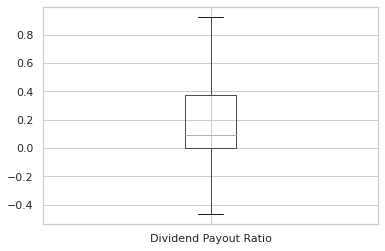

Equity Multiplier


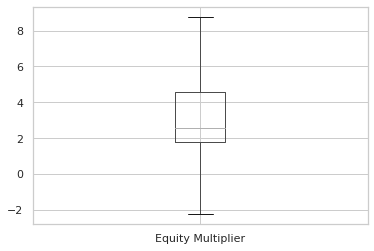

Gross Profit/Total Assets


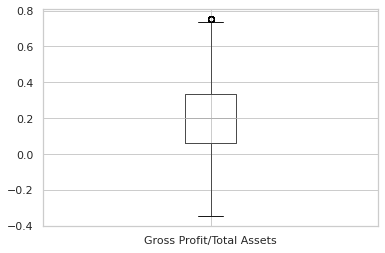

ROA


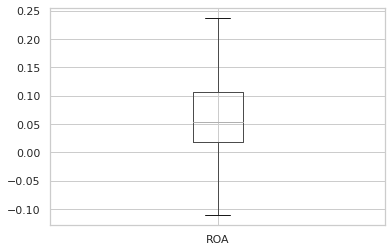

ROE


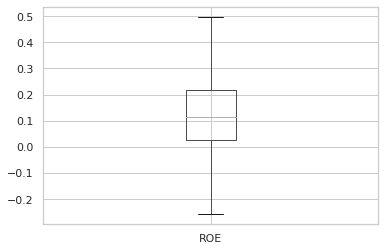

Book/Price


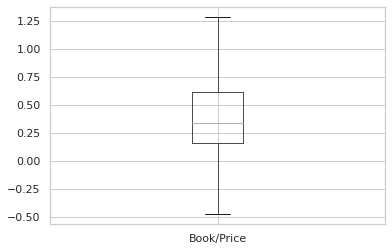

E/P


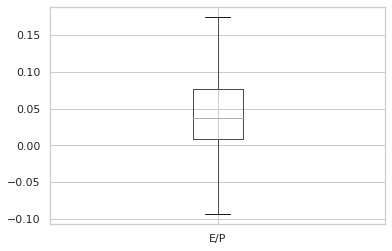

EBIT/P


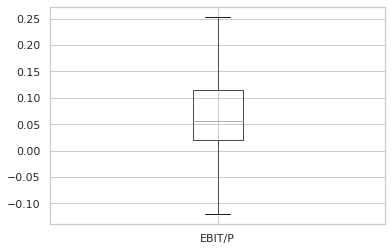

SALE/P


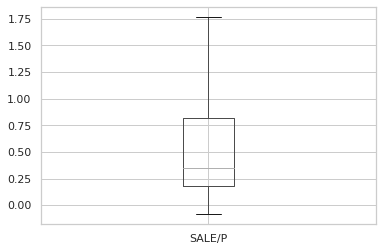

1/nim


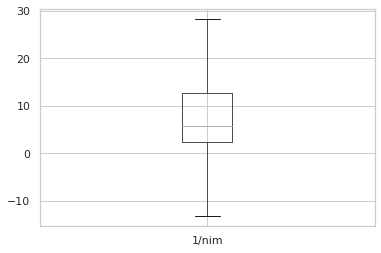

1/pe_exi


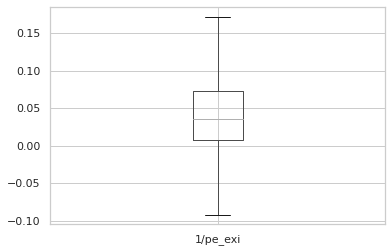

In [51]:
# Check there are not any outliers and
# we have new maximum and minimum points.
for i in ratios.columns[-12:]:
    print(i)
    plt.figure()
    ratios.boxplot(column=i)
    plt.show()

### Compare the orginal data to the new data
- We make upper and lower limits from IQR for the new maximum and minimum points.
- No changes on median-logic descriptive statistical value, but mean-logic descriptive statistical values change

- Seems to more logical

In [52]:
df.describe()

,divyield,Dividend Payout Ratio,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.015208,0.371677,1.469272,0.217461,0.047180,0.023312,0.422120,0.027009,0.060538,0.765997,16.520010,0.020671
std,0.028262,4.079297,89.376561,0.235335,0.157399,10.319606,0.424100,0.136353,0.130324,1.439881,338.241713,0.143227
min,-0.000013,-90.398959,-3095.952381,-1.384604,-1.420596,-364.326147,-2.056645,-1.891725,-1.334204,-0.087004,-2719.142117,-1.955975
25%,0.000000,0.000000,1.770975,0.058168,0.018602,0.027054,0.161112,0.008113,0.019641,0.176223,2.341540,0.007117
50%,0.007126,0.092851,2.552746,0.198943,0.053231,0.115155,0.337004,0.036704,0.056821,0.350729,5.791435,0.035480
75%,0.022818,0.371872,4.577301,0.332409,0.106175,0.218230,0.613868,0.076322,0.113822,0.814565,12.766705,0.072964
max,0.738044,118.595914,1347.744089,2.845149,1.908472,216.142857,7.547555,0.898517,0.974888,27.543662,13507.605839,0.674523


In [53]:
cols = df.columns
ratios[df.columns].describe()

,divyield,Dividend Payout Ratio,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.013363,0.220363,3.472437,0.215568,0.059448,0.116821,0.410976,0.037521,0.064288,0.578729,7.442823,0.035132
std,0.016085,0.317797,2.744725,0.196735,0.083335,0.197030,0.340923,0.065144,0.085263,0.542636,10.938735,0.063167
min,-0.000013,-0.469309,-2.250399,-0.349151,-0.111284,-0.258207,-0.476140,-0.094015,-0.121045,-0.087004,-13.240575,-0.091644
25%,0.000000,0.000000,1.770975,0.058168,0.018602,0.027054,0.161112,0.008113,0.019641,0.176223,2.341540,0.007117
50%,0.007126,0.092851,2.552746,0.198943,0.053231,0.115155,0.337004,0.036704,0.056821,0.350729,5.791435,0.035480
75%,0.022818,0.371872,4.577301,0.332409,0.106175,0.218230,0.613868,0.076322,0.113822,0.814565,12.766705,0.072964
max,0.057018,0.926306,8.770750,0.754040,0.237294,0.497894,1.289098,0.175014,0.253585,1.769416,28.357576,0.171696


## Calculate Save the ticker symbol and the 10+ financial ratios for each stock in the list in a CSV file labelled “Fin-Ratios.csv”.

In [54]:
filepath = Path('/content/gdrive/MyDrive/Fin-Ratios.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
ratios.to_csv(filepath)

# (4) Industry Indicators

## a. Determine industry indicators for each stock in the list.

In [55]:
sector.rename({'tic': 'Ticker'}, axis=1, inplace=True)
sector = sector[['Ticker','ggroup']]
Industry = pd.get_dummies(sector, columns=['ggroup'])

### EDA for Industry Indicators

In [56]:
GIC = pd.read_excel('/content/gdrive/MyDrive/2018-gics-changes.xlsx')

In [57]:
GIC = GIC.iloc[:,2:4]
GIC.dropna(inplace=True)
GIC=GIC.rename(columns={"Unnamed: 2": "ggroup", "Unnamed: 3": "Industry Group"}).reset_index()
GIC.drop(columns='index',inplace=True)
GIC = GIC.drop_duplicates(subset=['ggroup']).reset_index()
GIC_data = sector.merge(GIC,on = 'ggroup',how='left')
GIC_data.drop(columns=['index','ggroup'],inplace=True)
GIC_data

,Ticker,Industry Group
0,AIR,Capital Goods
1,AAL,Transportation
2,PNW,Utilities
3,ABT,Health Care Equipment & Services
4,AMD,Semiconductors & Semiconductor Equipment
...,...,...
1881,KRG,Real Estate
1882,LYB,Materials
1883,FRO,Energy
1884,ALLE,Capital Goods


In [58]:
sector_count = GIC_data.groupby('Industry Group').count()
sector_count.sort_values('Ticker', inplace = True)
sector_count.rename(columns={"Ticker": "Count"},inplace=True)
sector_count.reset_index(inplace=True)
sector_count['percentage %'] = sector_count['Count']/1886*100
sector_count.head(3)

,Industry Group,Count,percentage %
0,Telecommunication Services,13,0.689290
1,Household & Personal Products,17,0.901379
2,Food & Staples Retailing,17,0.901379


Lowest: The number of stocks in Telecommunication Services industry is 13(0.68%)

In [59]:
sector_count.sort_values('Count', ascending = False).head(2)

,Industry Group,Count,percentage %
23,Capital Goods,183,9.703075
22,Banks,179,9.490986


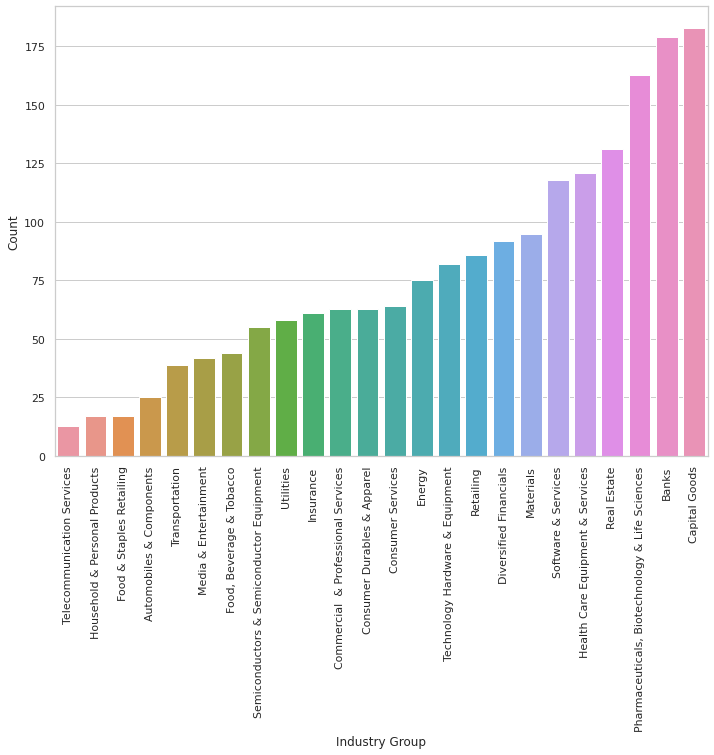

In [60]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Industry Group', y='Count', data=sector_count)
plt.xticks(rotation=90)
plt.show()

In [61]:
GIC_ret = GIC_data.merge(ProjectTickers,on = 'Ticker',how='left')
GIC_ret = GIC_ret[['Industry Group','RetYTD']]
GIC_ret

,Industry Group,RetYTD
0,Capital Goods,0.2944
1,Transportation,0.0579
2,Utilities,0.0985
3,Health Care Equipment & Services,-0.1638
4,Semiconductors & Semiconductor Equipment,-0.3533
...,...,...
1881,Real Estate,0.0275
1882,Materials,0.1664
1883,Energy,0.3380
1884,Capital Goods,-0.1888


In [62]:
ret_count = GIC_ret.groupby('Industry Group').mean().reset_index()
ret_count.sort_values('RetYTD',ascending=False)

,Industry Group,RetYTD
7,Energy,0.515035
8,Food & Staples Retailing,0.078312
13,Materials,0.057846
23,Utilities,0.040759
9,"Food, Beverage & Tobacco",0.038780
21,Telecommunication Services,0.011838
12,Insurance,0.003779
3,Commercial & Professional Services,-0.035157
16,Real Estate,-0.035826
5,Consumer Services,-0.062583


In [63]:
ret_count.RetYTD.mean()

-0.05466304202939218

In [64]:
ret_count['diff on Avg'] = ret_count.RetYTD - ret_count.RetYTD.mean()

In [65]:
ret_count.sort_values('diff on Avg').head(2)

,Industry Group,RetYTD,diff on Avg
18,Semiconductors & Semiconductor Equipment,-0.252813,-0.198150
4,Consumer Durables & Apparel,-0.208598,-0.153935


In [66]:
ret_count.sort_values('diff on Avg', ascending=False).head(3)

,Industry Group,RetYTD,diff on Avg
7,Energy,0.515035,0.569698
8,Food & Staples Retailing,0.078312,0.132975
13,Materials,0.057846,0.112509


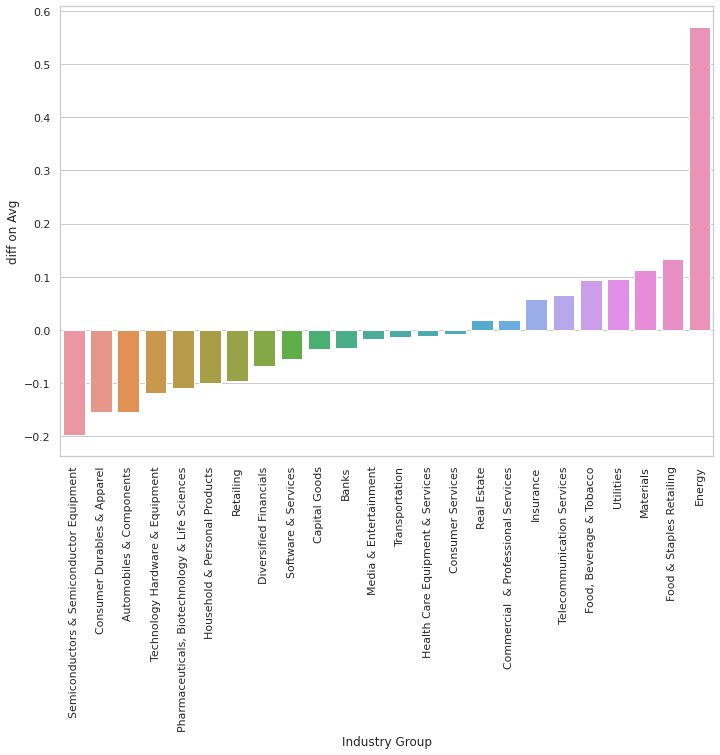

In [67]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Industry Group', y='diff on Avg', data=ret_count.sort_values('diff on Avg'))
plt.xticks(rotation=90)
plt.show()

## b. Save the ticker symbol and the industry indicators for each stock in the list in a CSV file labelled “Industry.csv”.

In [68]:
# Save the merged datasets in a file called "Industry.csv".
from pathlib import Path  
filepath = Path('/content/gdrive/MyDrive/Industry.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Industry.to_csv(filepath) 

# (5) Run OLS explanatory for 4 categories:

## a. Risk Regressions:

### i. Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) + b3*ValueExposure(i) + e

In [69]:
# Merge the Risk Exposures and stock return on Ticker
Risk_Exposures.rename({'TICKER':'Ticker'},axis=1, inplace=True)
risk_data = pd.merge(ProjectTickers,Risk_Exposures,on = 'Ticker',how='outer')

In [70]:
risk_data

,Ticker,Name,RetYTD,mktrf,smb,hml
0,A,Agilent Technologies,-0.2080,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1.984149,0.527862,1.924844
2,AAL,American Airlines Gp,0.0579,1.315550,0.612825,1.248123
3,AAN,Aarons Holdings Company,-0.1327,1.643201,0.171044,0.833796
4,AAON,Aaon Inc,-0.3456,0.516779,0.422130,-0.117068
...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,1.026803,1.363839,-0.774104
1882,ZION,Zions Bancorp,-0.0038,1.084739,0.869374,1.151468
1883,ZNGA,Zynga Inc Cl A,0.3969,0.101034,1.200987,-0.714916
1884,ZTS,Zoetis Inc Cl A,-0.2325,0.728418,-0.560814,-0.179065


In [71]:
risk_data.describe()

,RetYTD,mktrf,smb,hml
count,1886.000000,1886.000000,1886.000000,1886.000000
mean,-0.063484,1.065369,0.667275,0.317248
std,0.243801,0.624558,1.232195,0.699352
min,-0.787400,-6.676723,-6.286219,-3.593321
25%,-0.199450,0.720385,0.016011,-0.047773
50%,-0.086750,1.006944,0.501588,0.360752
75%,0.038750,1.337691,1.019407,0.760726
max,1.735700,6.002016,31.005941,5.919490


In [72]:
# add constant column to the original dataframe

# define x as a subset of original dataframe
x1 = risk_data.drop(columns=['Ticker','Name ','RetYTD'])
# define y as stock return
y = risk_data.RetYTD
x1 = sm.add_constant(x1)
# pass x as a dataframe, while pass y as stock return
output = sm.OLS(y, x1).fit()
output.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     65.51
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           2.73e-40
Time:                        01:19:25   Log-Likelihood:                 79.956
No. Observations:                1886   AIC:                            -151.9
Df Residuals:                    1882   BIC:                            -129.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0981      0.011     -8.783      0.000      -0.120      -0.076
mktrf          0.0082      0.009      0.957      0.339      -0.009       0.025
smb           -0.0120      0.004     -2.736      0.006      -0.021      -0.003
hml            0.1068      0.008     13.815      0.000       0.092       0.122
==============================================================================
Omnibus:                      642.181   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3599.682
Skew:                           1.492   Prob(JB):                         0.00
Kurtosis:                       9.074   Cond. No.                         4.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ii. Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

In [73]:
d = output.rsquared
e = output.rsquared_adj
c = output.params

output = pd.DataFrame({
          'R-squared':d,
          'Adj.R-squared':e,
          'const':c[0],
          'mktrf':c[1],
          'smb':c[2],
          'hml':c[3]},index=[0])

In [74]:
output

,R-squared,Adj.R-squared,const,mktrf,smb,hml
0,0.094557,0.093114,-0.098132,0.00823,-0.011982,0.106778


### Interpretations:
- `R-squared` is 0.095 means that 9.5% of the return of these stocks is explained by the market fluctuations. Also low R-squared indicates a low
correlation between these stocks' returns and the stock returns for companies for early 2022.
- `Adjusted R-square` is 0.093 means that this model has a small explainatory power of the stock returns.

- `constant` is -0.10 with p-value(0.00<0.05), which is statistically significant, means that these stocks went down on average by 1% that is not explained by the market. In other words, the stock failed to generate the returns as expected by the model. 
- `mktrf` is 0.00823 with p-value(0.339>0.05), means we cannot rule out that possible that these stocks are less exposed on average than most stocks compare to the market fluctuations.
- `smb` is -0.012 with p-value(0.006<0.05),which is statistically significant, means that these stocks on averge are large stocks with less riskiness.
-  `hml` is 0.11 with p-value(0.00), which is statistically significant, means that these stocks on average are value stocks.

In conclusion, these stocks are **"large"** and **"value"** stocks on average, it make sense because the stock returns are higher in large and value stocks than the stocks which are small and growth. In other words, these stocks on average has lower volatility, with larger size and valued stock tend to generate higher stock return in early 2022.


## b. Financial Characteristics:

### i. Ret(i) = a + c1*Ratio1(i) + c2*Ratio2(i) + … + c10*Ratio10 (i) + e

In [75]:
# Merge the financial ratios and stock return on Ticker
ratios.rename({'tic':'Ticker'},axis=1, inplace=True)
ratio_data = pd.merge(ProjectTickers,ratios,on = 'Ticker',how='outer')
ratio_data

,Ticker,Name,RetYTD,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,...,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,E/P,EBIT/P,SALE/P,1/nim,1/pe_exi
0,A,Agilent Technologies,-0.2080,126554,20211031,2021,INDL,C,D,STD,...,1.986454,0.340682,0.131621,0.224531,0.111695,0.025079,0.029204,0.130970,5.222314,0.024679
1,AA,Alcoa Corp,0.4731,27638,20211231,2021,INDL,C,D,STD,...,3.215967,0.199601,0.138236,0.091824,0.425940,0.039111,0.189357,1.107882,28.326340,0.037932
2,AAL,American Airlines Gp,0.0579,1045,20211231,2021,INDL,C,D,STD,...,-2.250399,0.028781,-0.082958,0.271526,-0.476140,-0.094015,-0.121045,1.769416,-13.240575,-0.091644
3,AAN,Aarons Holdings Company,-0.1327,37445,20211231,2021,INDL,C,D,STD,...,2.006869,0.754040,0.109513,0.153076,0.940491,0.143967,0.206699,1.769416,16.787382,0.132252
4,AAON,Aaon Inc,-0.3456,21542,20211231,2021,INDL,C,D,STD,...,1.394727,0.254159,0.113249,0.126044,0.111730,0.014083,0.017648,0.128111,9.096923,0.013723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,20229,20211231,2021,INDL,C,D,STD,...,5.010607,0.448148,-0.061774,-0.258207,0.038577,-0.017636,-0.011941,0.105556,-5.985419,-0.017931
1882,ZION,Zions Bancorp,-0.0038,11687,20211231,2021,INDL,C,D,STD,...,8.770750,0.034195,0.019324,0.160758,0.733347,0.117891,0.188062,0.310130,2.630647,0.107505
1883,ZNGA,Zynga Inc Cl A,0.3969,187576,20211231,2021,INDL,C,D,STD,...,2.043414,0.318373,0.037019,-0.033484,0.430106,-0.014402,0.032535,0.387066,-13.240575,-0.014062
1884,ZTS,Zoetis Inc Cl A,-0.2325,13721,20211231,2021,INDL,C,D,STD,...,3.059652,0.416978,0.204245,0.448382,0.039394,0.017664,0.024618,0.067515,3.822288,0.017498


In [76]:
# Select the finacial ratios we need
cols = ratios.columns[-12:]

# define x as a subset of original dataframe
x2 = ratio_data[cols]
# define y as stock return
y = ratio_data.RetYTD
# add constant column to the original dataframe
x2 = sm.add_constant(x2)
# pass x as a dataframe, while pass y as stock return
ratio_model = sm.OLS(y, x2).fit()
ratio_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     16.36
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.41e-33
Time:                        01:19:26   Log-Likelihood:                 80.292
No. Observations:                1886   AIC:                            -134.6
Df Residuals:                    1873   BIC:                            -62.54
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.1615      0.015    -10.444      0.000      -0.192      -0.131
divyield                      0.9213      0.542      1.700      0.089      -0.142       1.984
Dividend Payout Ratio         0.0440      0.027      1.649      0.099      -0.008       0.096
Equity Multiplier            -0.0046      0.002     -1.982      0.048      -0.009   -4.85e-05
Gross Profit/Total Assets    -0.0944      0.039     -2.441      0.015      -0.170      -0.019
ROA                           0.4018      0.119      3.368      0.001       0.168       0.636
ROE                           0.0308      0.040      0.779      0.436      -0.047       0.108
Book/Price                    0.1527      0.022      6.912      0.000       0.109       0.196
E/P                          -0.0567      0.331     -0.171      0.864      -0.707       0.593
EBIT/P                        0.1690      0.134      1.263      0.207      -0.093       0.431
SALE/P                        0.0726      0.013      5.732      0.000       0.048       0.097
1/nim                        -0.0012      0.001     -1.912      0.056      -0.002       3e-05
1/pe_exi                     -0.5677      0.356     -1.594      0.111      -1.266       0.131
==============================================================================
Omnibus:                      664.801   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4238.860
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                       9.697   Cond. No.                     1.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### ii. Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

In [77]:
a = ratio_model.rsquared
b = ratio_model.rsquared_adj
c = ratio_model.params
d = ratio_model.tvalues
output = pd.DataFrame({
          'R-squared':a,
          'Adj.R-squared':b},index=[0])

print(output)
tt1 = pd.DataFrame(c,columns=['cof']).reset_index()
tt2 = pd.DataFrame(d,columns=['t_stat']).reset_index()
tt = tt1.merge(tt2, on='index')
tt.sort_values('cof',ascending = False)

   R-squared  Adj.R-squared
0   0.094881       0.089082


,index,cof,t_stat
1,divyield,0.921279,1.699861
5,ROA,0.401761,3.367535
9,EBIT/P,0.168964,1.263449
7,Book/Price,0.152737,6.912207
10,SALE/P,0.072586,5.732152
2,Dividend Payout Ratio,0.044044,1.649012
6,ROE,0.030782,0.779040
11,1/nim,-0.001169,-1.912193
3,Equity Multiplier,-0.004608,-1.982081
8,E/P,-0.056733,-0.171236


### **Interpretations**: 

Accroding to **R-square**, we can conclude 9.4% variance in the stock returns for companies for early 2022 can be explained by these ratios. In other words, the low R-squared indicates a low
correlation between these financial ratios and the stock returns for companies for early 2022.

For **Adjusted R Square**, we can find the adjusted R Square of this regression is around 8.9%, representing a very low accuracy. Also, it means that this model has a small explainatory power of the stock returns.


For the values of coefficients, we can conclude:

> **Postive Coefficients**

- if '*divyield*' increases by 1, the *RetYTD* would increase by 0.921 

- if *ROA* increase to 1, the *RetYTD* would increase by 0.40

- if *EBIT/P ratio* increase to 1, the *RetYTD* would increase by  0.17

- if *Book/Price* increase to 1, the *RetYTD* would increase by  0.15

- if *SALE/P ratio* increase to 1, the *RetYTD* would increase by  0.07

- if *Dividend Payout Ratio* increase to 1, the *RetYTD* would increase by 0.04

- if *ROE* increase to 1, the *RetYTD* would increase by 0.03

> **Negative Coefficients**

- if *1/nim* increase to 1, the *RetYTD* would decrease by 0.001

- if *Equity Multiplier* increase to 1, the *RetYTD* would decrease by 0.005

- if *E/P ratio* increase to 1, the *RetYTD* would decrease by 0.06

- if *Gross Profit/Total Assets* increase to 1, the *RetYTD* would decrease by 0.09

- if *1/pe_exi* increase to 1, the *RetYTD* would decrease by 0.57


Thus, we can conclude that:
- **Positive coefficients** have positive effects on *RetYTD*, which means the rise of these ratios can increase in the stock returns for companies for early 2022. Among these ratios, *divyield* has the largest positive effect whereas *Dividend Payout Ratio* has the lowest positive effect on *RetYTD*. 

- **Negative coefficients** have negative effects on *RetYTD*, which means the rise of these ratios would decrease in the stock returns for companies for early 2022. Among these ratios, *1/pe_exi* has the largest negative effect whereas *1/nim* has the lowest negative effect on *RetYTD*. 

Based the **t-stats**, we can conclude that:
>**Statistically Significant**(the absolute values of test statistic are greater than 1.96)

*ROA*, *Book/Price*, *SALE/P ratio*, *Equity Multiplier*, and *Gross Profit/Total Assets*

>**Not Statistically Significant**(the absolute values of test statistic are smaller than 1.96)

*divyield*, *EBIT/P ratio*, *Dividend Payout Ratio*, *ROE*, *1/nim*, *E/P ratio*, *1/pe_exi*



In conclusion, these ratios have a low explainatory power of the stock returns for companies for early 2022. This is because ratio regression is used by the stocks to compare to other stocks which have the same size and type. Moreover, it exists the human element of the stocks that cannot be measured.





## c. Industry Dummies:

## i. Ret(i) = a + coefficients*IndustryDummies + e

In [78]:
# Merge the Industry dummies and stock return on Ticker
Industry_data = pd.merge(ProjectTickers,Industry,on = 'Ticker',how='outer')
Industry_data

,Ticker,Name,RetYTD,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,Agilent Technologies,-0.2080,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Corp,0.4731,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAL,American Airlines Gp,0.0579,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAN,Aarons Holdings Company,-0.1327,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAON,Aaon Inc,-0.3456,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,Zendesk Inc,0.2002,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1882,ZION,Zions Bancorp,-0.0038,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1883,ZNGA,Zynga Inc Cl A,0.3969,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1884,ZTS,Zoetis Inc Cl A,-0.2325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# define x as a subset of original dataframe
# set the 'ggroup_2530' as the constant
# because it is closed to the mean
x3 = Industry_data.drop(columns=['Ticker', 'RetYTD','Name ','ggroup_2530'])  
# add constant column to the original dataframe
x3['constant'] = 1
# define y as stock return
y = Industry_data.RetYTD

# pass x as a dataframe, while pass y as stock return
Industry_model = sm.OLS(y, x3).fit()
Industry_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        01:19:26   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1010     0.5776      0.034     16.849      0.000       0.510       0.645
ggroup_1510     0.1204      0.033      3.697      0.000       0.057       0.184
ggroup_2010    -0.0280      0.029     -0.956      0.339      -0.085       0.029
ggroup_2020     0.0274      0.036      0.767      0.443      -0.043       0.098
ggroup_2030    -0.0049      0.041     -0.119      0.905      -0.085       0.075
ggroup_2510    -0.1454      0.048     -3.060      0.002      -0.239      -0.052
ggroup_2520    -0.1460      0.036     -4.084      0.000      -0.216      -0.076
ggroup_2550    -0.0886      0.033     -2.665      0.008      -0.154      -0.023
ggroup_3010     0.1409      0.055      2.563      0.010       0.033       0.249
ggroup_3020     0.1014      0.039      2.569      0.010       0.024       0.179
ggroup_3030    -0.0912      0.055     -1.659      0.097      -0.199       0.017
ggroup_3510    -0.0038      0.031     -0.124      0.902      -0.065       0.057
ggroup_3520    -0.1014      0.030     -3.411      0.001      -0.160      -0.043
ggroup_4010    -0.0252      0.029     -0.861      0.390      -0.083       0.032
ggroup_4020    -0.0599      0.033     -1.828      0.068      -0.124       0.004
ggroup_4030     0.0664      0.036      1.841      0.066      -0.004       0.137
ggroup_4510    -0.0461      0.031     -1.473      0.141      -0.107       0.015
ggroup_4520    -0.1095      0.034     -3.258      0.001      -0.175      -0.044
ggroup_4530    -0.1902      0.037     -5.136      0.000      -0.263      -0.118
ggroup_5010     0.0744      0.061      1.214      0.225      -0.046       0.195
ggroup_5020    -0.0083      0.040     -0.207      0.836      -0.087       0.070
ggroup_5510     0.1033      0.037      2.829      0.005       0.032       0.175
ggroup_6010     0.0268      0.031      0.871      0.384      -0.034       0.087
constant       -0.0626      0.025     -2.485      0.013      -0.112      -0.013
==============================================================================
Omnibus:                      403.265   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2314.656
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       8.136   Cond. No.                         28.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ii. Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

In [80]:
a = Industry_model.rsquared
b = Industry_model.rsquared_adj
c = Industry_model.params
d = Industry_model.tvalues
output = pd.DataFrame({
          'R-squared':a,
          'Adj.R-squared':b},index=[0])

print(output)
tt1 = pd.DataFrame(c,columns=['cof']).reset_index()
tt2 = pd.DataFrame(d,columns=['t_stat']).reset_index()
tt = tt1.merge(tt2, on='index')
tt.sort_values('cof',ascending = False)

   R-squared  Adj.R-squared
0   0.325504       0.317172


,index,cof,t_stat
0,ggroup_1010,0.577617,16.848534
8,ggroup_3010,0.140895,2.563155
1,ggroup_1510,0.120429,3.696523
21,ggroup_5510,0.103341,2.829483
9,ggroup_3020,0.101362,2.569152
19,ggroup_5010,0.074421,1.214289
15,ggroup_4030,0.066362,1.840877
3,ggroup_2020,0.027426,0.767051
22,ggroup_6010,0.026757,0.870867
11,ggroup_3510,-0.003849,-0.123623


### **Interpretations**:

Accroding to **R-square**, we can conclude 32.6% variance in the stock returns for companies for early 2022 can be explained by these industry. In other words, this R-squared indicates a relatively high
correlation between these industry  and the stock returns for companies for early 2022.

For **Adjusted R Square**, we can find the adjusted R Square of this regression is around 31.7%, representing a relative high accuracy. To compare with the regression models above, this model has a much more explanatory power of the stock returns.


For the values of coefficients, we can conclude that the constant represents the `ggroup_2530` which is the most closed to the mean of RET. Thus, the other coefficients means the difference of the average returns for the individual industry relative to 'ggroup_2530'.

For example:

- **Positive coefficients**:
 
 The coefficients plus the constant is positive, which have positive effects on *RetYTD*, which means the rise of the average returns in these industries can increase in the stock returns for companies for early 2022. Among these industries, ggroup_1010, `Energy industry` has the largest positive effect. 
>- if the average returns of *Energy industry* increase to 1, the *RetYTD* would increase by 0.515035 (0.577617-0.062583)
- **Negative coefficients** 
 The coefficients plus the constant is negative, which have negative effects on *RetYTD*, which means the rise of the average returns in these industries would decrease in the stock returns for companies for early 2022. Among these ratios, ggroup_4530,`Semiconductors & Semiconductor Equipment industry` has the largest negative effect.
 >- if the average returns of *Semiconductors & Semiconductor Equipment industry* increase to 1, the *RetYTD* would decrease by 0.252813	(-0.190230-0.062583)

From the results above, we can conclude that 
- The highest return industry is *industry group 1010*, which is **Energy**.
- The lowest one is *industry group 4530*, which is **Semiconductors & Semiconductor Equipment**.

Both of these industries make economic sense for early 2022(RetYTD) because the p-value, t-value, and CI show they are statistically significance. Especially, the p-value of industry group 1010, Energy, is round to 0. Moreover, in the real world, oil price rise a lot and semiconductor has supply chain issues. This is because of the increased tensions between Ukraine and Russia.






## d. Combined Regressions:

### i. Combine the various regressions in steps (a-c) above.

### Combine all variables above

In [81]:
# keep three risk exposures without the constant
x1.drop(columns='const',inplace = True)

# keep 10 finacial ratios without the constant
x2.drop(columns='const',inplace = True)

# Select 24 Industry indicators
x3 = Industry_data.drop(columns=['Ticker', 'RetYTD','Name '])

# Merge three Risk Exposures, Finacial Ratios, Industry dummies on index
# X = pd.concat([x1, x2, x3], axis=1)
X = pd.concat([x1,x2,x3], axis=1)
# Check the variables in X are needed
X

,mktrf,smb,hml,divyield,Dividend Payout Ratio,Equity Multiplier,Gross Profit/Total Assets,ROA,ROE,Book/Price,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,1.014152,-0.253674,-0.143608,0.004891,0.195041,1.986454,0.340682,0.131621,0.224531,0.111695,...,0,0,0,0,0,0,0,0,0,0
1,1.984149,0.527862,1.924844,0.001732,0.044289,3.215967,0.199601,0.138236,0.091824,0.425940,...,0,0,0,0,0,0,0,0,0,0
2,1.315550,0.612825,1.248123,0.000000,-0.000000,-2.250399,0.028781,-0.082958,0.271526,-0.476140,...,0,0,0,0,0,0,0,0,0,0
3,1.643201,0.171044,0.833796,0.017377,0.120700,2.006869,0.754040,0.109513,0.153076,0.940491,...,0,0,0,0,0,0,0,0,0,0
4,0.516779,0.422130,-0.117068,0.004781,0.339477,1.394727,0.254159,0.113249,0.126044,0.111730,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1.026803,1.363839,-0.774104,0.000000,-0.000000,5.010607,0.448148,-0.061774,-0.258207,0.038577,...,0,0,0,1,0,0,0,0,0,0
1882,1.084739,0.869374,1.151468,0.027254,0.231178,8.770750,0.034195,0.019324,0.160758,0.733347,...,1,0,0,0,0,0,0,0,0,0
1883,0.101034,1.200987,-0.714916,0.000000,-0.000000,2.043414,0.318373,0.037019,-0.033484,0.430106,...,0,0,0,0,0,0,0,1,0,0
1884,0.728418,-0.560814,-0.179065,0.004414,0.249877,3.059652,0.416978,0.204245,0.448382,0.039394,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Add constant
X = sm.add_constant(X)

# define y as stock return
y = ProjectTickers.RetYTD

# pass x as a dataframe, while pass y as stock return
Combined_model = sm.OLS(y, X).fit()
Combined_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     30.08
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          8.45e-164
Time:                        01:19:26   Log-Likelihood:                 440.59
No. Observations:                1886   AIC:                            -803.2
Df Residuals:                    1847   BIC:                            -587.0
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.1194      0.019     -6.355      0.000      -0.156      -0.083
mktrf                        -0.0138      0.008     -1.645      0.100      -0.030       0.003
smb                          -0.0184      0.004     -4.222      0.000      -0.027      -0.010
hml                           0.0670      0.009      7.660      0.000       0.050       0.084
divyield                      0.6914      0.460      1.505      0.133      -0.210       1.593
Dividend Payout Ratio        -0.0047      0.023     -0.202      0.840      -0.050       0.041
Equity Multiplier             0.0008      0.002      0.361      0.718      -0.004       0.005
Gross Profit/Total Assets     0.0324      0.038      0.856      0.392      -0.042       0.107
ROA                           0.0647      0.108      0.600      0.548      -0.147       0.276
ROE                           0.0309      0.033      0.929      0.353      -0.034       0.096
Book/Price                    0.0875      0.020      4.431      0.000       0.049       0.126
E/P                          -0.3155      0.278     -1.133      0.257      -0.861       0.230
EBIT/P                        0.0879      0.120      0.731      0.465      -0.148       0.324
SALE/P                        0.0200      0.013      1.489      0.137      -0.006       0.046
1/nim                        -0.0006      0.001     -1.073      0.284      -0.002       0.000
1/pe_exi                      0.1948      0.301      0.646      0.518      -0.396       0.786
ggroup_1010                   0.5216      0.025     20.760      0.000       0.472       0.571
ggroup_1510                   0.0854      0.020      4.244      0.000       0.046       0.125
ggroup_2010                  -0.0371      0.015     -2.427      0.015      -0.067      -0.007
ggroup_2020                   0.0127      0.025      0.516      0.606      -0.035       0.061
ggroup_2030                  -0.0447      0.031     -1.448      0.148      -0.105       0.016
ggroup_2510                  -0.1679      0.038     -4.361      0.000      -0.243      -0.092
ggroup_2520                  -0.1729      0.025     -6.942      0.000      -0.222      -0.124
ggroup_2530                   0.0176      0.025      0.716      0.474      -0.031       0.066
ggroup_2550                  -0.1079      0.024     -4.565      0.000      -0.154      -0.062
ggroup_3010                   0.1033      0.048      2.153      0.031       0.009       0.197
ggroup_3020                   0.0743      0.029      2.548      0.011       0.017       0.131
ggroup_3030                  -0.1014      0.046     -2.192      0.029      -0.192      -0.011
ggroup_3510                   0.0401      0.019      2.139      0.033       0.003       0.077
ggroup_3520                  -0.0007      0.019     -0.038      0.970      

In [83]:
a = Combined_model.rsquared
b = Combined_model.rsquared_adj
c = Combined_model.params
d = Combined_model.tvalues
output = pd.DataFrame({
          'R-squared':a,
          'Adj.R-squared':b},index=[0])

print(output)
tt1 = pd.DataFrame(c,columns=['cof']).reset_index()
tt2 = pd.DataFrame(d,columns=['t_stat']).reset_index()
tt = tt1.merge(tt2, on='index')
tt.sort_values('cof',ascending = False)

   R-squared  Adj.R-squared
0   0.382308       0.369599


,index,cof,t_stat
4,divyield,0.691426,1.504702
16,ggroup_1010,0.521639,20.760077
15,1/pe_exi,0.194770,0.646063
25,ggroup_3010,0.103291,2.152715
12,EBIT/P,0.087900,0.731020
10,Book/Price,0.087514,4.430739
17,ggroup_1510,0.085396,4.243636
26,ggroup_3020,0.074309,2.548380
38,ggroup_5510,0.070098,2.584972
3,hml,0.067030,7.659885


### Combine the variables selected

In [84]:
X = pd.concat([x1,x2,x3], axis=1)
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
# drop  'Equity Multiplier', 'Gross Profit/Total Assets','1/pe_exi','Dividend Payout Ratio','EBIT/P','ggroup_3520','ggroup_4030','ggroup_6010'
X = X[['const', 'mktrf', 'smb', 'hml', 'divyield', 
         'ROA', 'ROE',
       'Book/Price', 'E/P',  'SALE/P', '1/nim', 
       'ggroup_1010', 'ggroup_1510', 'ggroup_2010', 'ggroup_2020',
       'ggroup_2030', 'ggroup_2510', 'ggroup_2520', 'ggroup_2530',
       'ggroup_2550', 'ggroup_3010', 'ggroup_3020', 'ggroup_3030',
       'ggroup_3510', 'ggroup_4010', 'ggroup_4020',
       'ggroup_4510', 'ggroup_4520', 'ggroup_4530',
       'ggroup_5010', 'ggroup_5020', 'ggroup_5510']]

# define y as stock return
y = ProjectTickers.RetYTD

# pass x as a dataframe, while pass y as stock return
Combined_model = sm.OLS(y, X).fit()
Combined_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     36.90
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.01e-168
Time:                        01:19:26   Log-Likelihood:                 439.50
No. Observations:                1886   AIC:                            -815.0
Df Residuals:                    1854   BIC:                            -637.7
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1188      0.017     -6.937      0.000      -0.152      -0.085
mktrf          -0.0130      0.008     -1.576      0.115      -0.029       0.003
smb            -0.0180      0.004     -4.222      0.000      -0.026      -0.010
hml             0.0678      0.008      8.103      0.000       0.051       0.084
divyield        0.6651      0.337      1.971      0.049       0.003       1.327
ROA             0.1461      0.082      1.772      0.077      -0.016       0.308
ROE             0.0261      0.032      0.812      0.417      -0.037       0.089
Book/Price      0.0866      0.019      4.594      0.000       0.050       0.124
E/P            -0.0960      0.114     -0.844      0.399      -0.319       0.127
SALE/P          0.0259      0.012      2.194      0.028       0.003       0.049
1/nim          -0.0006      0.000     -1.234      0.217      -0.002       0.000
ggroup_1010     0.5208      0.028     18.807      0.000       0.466       0.575
ggroup_1510     0.0885      0.024      3.708      0.000       0.042       0.135
ggroup_2010    -0.0353      0.019     -1.813      0.070      -0.074       0.003
ggroup_2020     0.0157      0.028      0.563      0.573      -0.039       0.071
ggroup_2030    -0.0459      0.034     -1.357      0.175      -0.112       0.020
ggroup_2510    -0.1661      0.042     -3.960      0.000      -0.248      -0.084
ggroup_2520    -0.1667      0.028     -5.853      0.000      -0.222      -0.111
ggroup_2530     0.0189      0.028      0.684      0.494      -0.035       0.073
ggroup_2550    -0.1006      0.026     -3.846      0.000      -0.152      -0.049
ggroup_3010     0.1127      0.051      2.226      0.026       0.013       0.212
ggroup_3020     0.0762      0.032      2.364      0.018       0.013       0.139
ggroup_3030    -0.0934      0.049     -1.902      0.057      -0.190       0.003
ggroup_3510     0.0462      0.021      2.155      0.031       0.004       0.088
ggroup_4010    -0.0955      0.021     -4.658      0.000      -0.136      -0.055
ggroup_4020    -0.1006      0.024     -4.223      0.000      -0.147      -0.054
ggroup_4510     0.0246      0.021      1.149      0.251      -0.017       0.067
ggroup_4520    -0.0936      0.025     -3.764      0.000      -0.142      -0.045
ggroup_4530    -0.1488      0.029     -5.127      0.000      -0.206      -0.092
ggroup_5010     0.0380      0.055      0.689      0.491      -0.070       0.146
ggroup_5020     0.0099      0.032      0.309      0.758      -0.053       0.073
ggroup_5510     0.0728      0.028      2.580      0.010       0.017       0.128
==============================================================================
Omnibus:                      448.961   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2607.015
Skew:                           0.988   Prob(J

In [86]:
a = Combined_model.rsquared
b = Combined_model.rsquared_adj
c = Combined_model.params
d = Combined_model.tvalues
output = pd.DataFrame({
          'R-squared':a,
          'Adj.R-squared':b},index=[0])

print(output)
tt1 = pd.DataFrame(c,columns=['cof']).reset_index()
tt2 = pd.DataFrame(d,columns=['t_stat']).reset_index()
tt = tt1.merge(tt2, on='index')
tt.sort_values('cof',ascending = False)

   R-squared  Adj.R-squared
0   0.381595       0.371254


,index,cof,t_stat
4,divyield,0.665118,1.971342
11,ggroup_1010,0.520793,18.807205
5,ROA,0.146065,1.771837
20,ggroup_3010,0.112657,2.226343
12,ggroup_1510,0.088485,3.707930
7,Book/Price,0.086609,4.593858
21,ggroup_3020,0.076210,2.364012
31,ggroup_5510,0.072847,2.580325
3,hml,0.067795,8.103451
23,ggroup_3510,0.046158,2.155129


### ii. Interpret and explain your findings (focus on R2, Adj R2 and coefficients)

### **Interpretations**:

For two combined models, the first model's variables are included all variables used on the three regression models above whereas the second model's variables are selected from all variables.


Accroding to **R-square**, they are 0.382308 and 0.381595. we can conclude around 38.2% variance in the stock returns for companies for early 2022 can be explained by these variables on both models. In other words, it indicates a relatively high correlation between these variables and the stock returns for companies for early 2022.

For **Adjusted R Square**, they are 0.370 and 0.371. Although the R-squared of the second one is slightly smaller than the first one but the Adjusted R-square is slightly higher than the first one. Thus, to compare with the regression models above and the first one, we can conclude that the second one has the best explanatory power of the stock returns.

Thus, we could use the second combined model to do more explanations:

For the values of coefficients, we can conclude:
- for three risk exposures, the p-value for `mktrf` with negative coeffcient is larger than 0.05 so we cannot rule out that possible that these stocks are less exposed on average than most stocks compare to the market fluctuations. Whereas, `smb` with negative coeffcient and `hml` with positive coeffcient indicates that **large** and **value** stocks are tend to earn more returns

- for 7 of 12 ratios, `divyield`, `Book/Price`, and `Sale/P` are statistical significance. Among three ratios, 'divyield' has the **largest positive effect** on the stock returns for companies for early 2022. Among the other ratios, `E/P` has the **largest negative effect** on the stock returns for companies for early 2022.
>- if *divyield* increase to 1, the *RetYTD* would increase by 0.67
 >- if *E/P* increase to 1, the *RetYTD* would decrease by 0.10(not statistically significant)


- for 21 of 24 industries, 13 of them are statistical significance. Among these industries, ggroup_1010, `Energy industry` has **the largest positive effect**. It also has the **second largest postive effect** on the stock returns for companies for early 2022. "ggroup_2520", `Consumer Durables & Apparel industry` has the **largest negative effect** on the stock returns for companies for early 2022 among all variables. 
> - if the average returns of *Energy industry* increase to 1, the *RetYTD* would increase by 0.52
>- if the average returns of *Consumer Durables & Apparel industry* increase to 1, the *RetYTD* would decrease by 0.17




From the results above, we can conclude that 
- The risk exposure variables indicate that **large** and **value** stocks are tend to earn more returns
- The highest return variable is `idivyield`
- The second highest one is ggroup_1010, `Energy industry`
- The lowest one is "ggroup_2520", `Consumer Durables & Apparel industry`
- The coefficient of `E/P` is -0.017 which means that `P/E` has a positive effect on the stock returns for companies for early 2022.(but not statistically significant)







### Summary and Recommendations
Among these five regression models, the last one, which use the selected variables, has the highest Adjusted R-squared. It means that this model lead most explanatory power, which is 37.1% of the stock returns for companies for early 2022. When comparing these models, we can find that the industry regression have the highest Adjusted R-squared among the models without combined models. In this case, we can think that investing on a right industry is very important. Also, from the last combined model, the second highest return variable is ggroup_1010, `Energy industry`. 

Thus, based on the analysis of this project, the **recommendations** for investors:
- Invest on **large** and **value** stocks are tend to earn more returns

- Invest on the right industry, like ggroup_1010, `Energy industry`. Also, check the industry carefully and avoid to invest on "ggroup_2520", `Consumer Durables & Apparel industry`

- Before buying a stock, checking its `Dividend Yield`, if it is high, you can buy it

- `P/E ratio` is a common ratio that each investor would check, but sometimes it is not a good way to estimate a stock's future returns. If you want to use this ratio, you have to do thorough research. In this analysis, we do not recommend you to use this ratio because it is not statistically significant in our regression model